In [207]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.preprocessing import KBinsDiscretizer
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.metrics import accuracy_score, precision_score, recall_score, classification_report  
from sklearn.model_selection import cross_val_score, cross_validate
from sklearn.dummy import DummyRegressor
from sklearn.preprocessing import PolynomialFeatures
from sklearn.metrics import mean_squared_log_error

In [208]:
df = pd.read_csv('../data/train.csv', index_col=0, parse_dates=True)

# Data columns:  

In [209]:
df.columns

Index(['season', 'holiday', 'workingday', 'weather', 'temp', 'atemp',
       'humidity', 'windspeed', 'casual', 'registered', 'count'],
      dtype='object')

In [210]:
for col in ['season', 'holiday', 'workingday', 'weather',]:
    print(df[col].value_counts())

4    2734
2    2733
3    2733
1    2686
Name: season, dtype: int64
0    10575
1      311
Name: holiday, dtype: int64
1    7412
0    3474
Name: workingday, dtype: int64
1    7192
2    2834
3     859
4       1
Name: weather, dtype: int64


# Creating new columns

In [211]:
df['hour'] = df.index.hour
df['weekday'] = df.index.weekday
df['month'] = df.index.month
df['year'] = df.index.year
df['month_count'] = df['month']+(df['year']-2011)*12
df.columns

Index(['season', 'holiday', 'workingday', 'weather', 'temp', 'atemp',
       'humidity', 'windspeed', 'casual', 'registered', 'count', 'hour',
       'weekday', 'month', 'year', 'month_count'],
      dtype='object')

Fix weather value '4' (heavy rain e.t.c) that apears only once

In [212]:
df['weather'].value_counts()

1    7192
2    2834
3     859
4       1
Name: weather, dtype: int64

In [213]:
df[df['weather']==4] = 3

# Data Exploration highlights

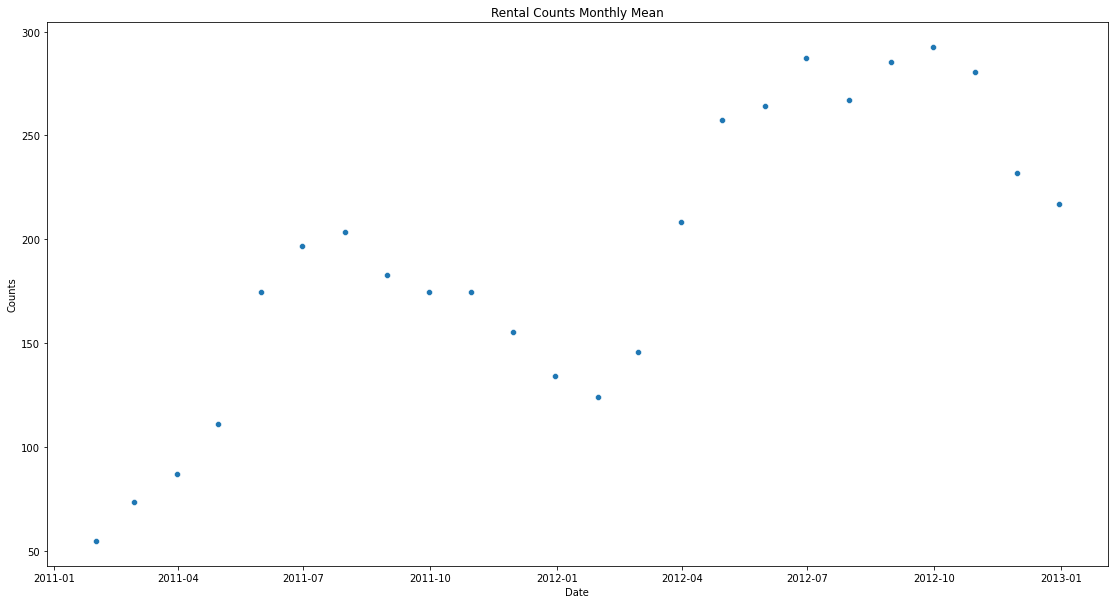

In [214]:
plt.figure(figsize=(19,10))
sns.scatterplot(data =df.resample('M').mean(), x = 'datetime', y ='count')
plt.ylabel('Counts')
plt.xlabel('Date')
plt.title('Rental Counts Monthly Mean')
plt.show()

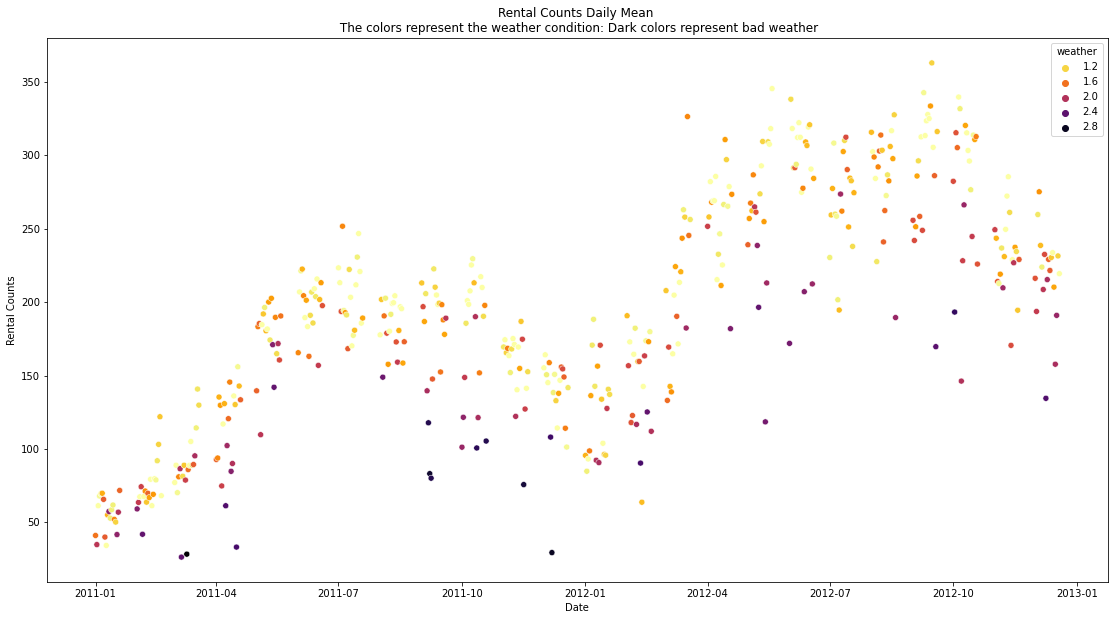

In [215]:
plt.figure(figsize=(19,10))
sns.scatterplot(data =df.resample('D').mean(), x = 'datetime', y ='count',hue='weather',palette="inferno_r")
plt.ylabel('Rental Counts')
plt.xlabel('Date')
plt.title('Rental Counts Daily Mean \n The colors represent the weather condition: Dark colors represent bad weather')
plt.show()

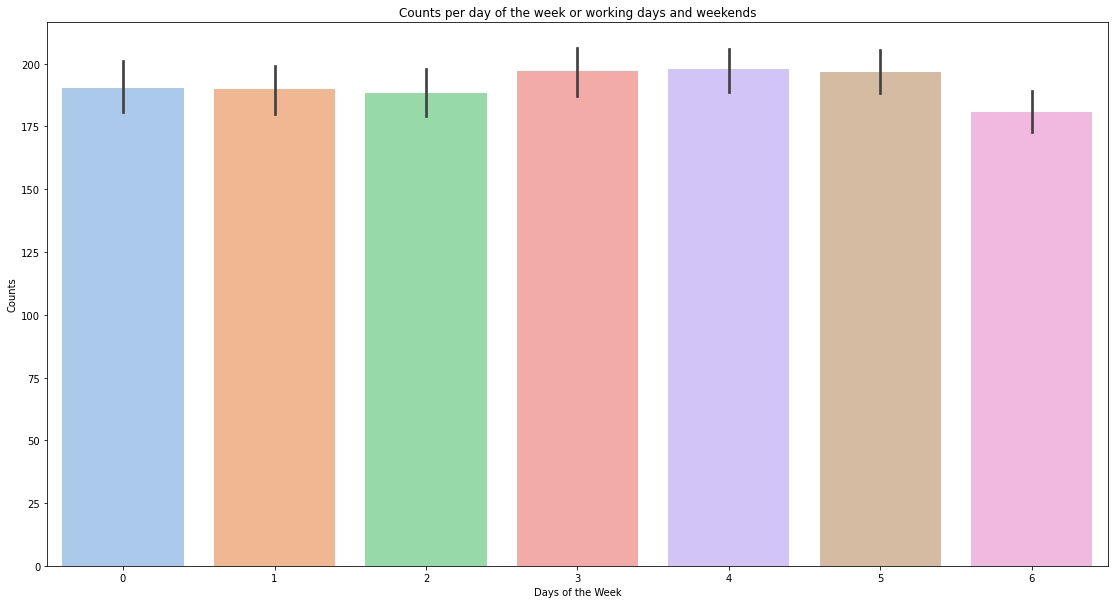

In [216]:
plt.figure(figsize=(19,10))
sns.barplot(data =df, x = 'weekday', y ='count', palette='pastel', ) #hue = 'workingday', 
plt.xlabel('Days of the Week')
plt.ylabel('Counts')
plt.title('Counts per day of the week or working days and weekends')
plt.show()

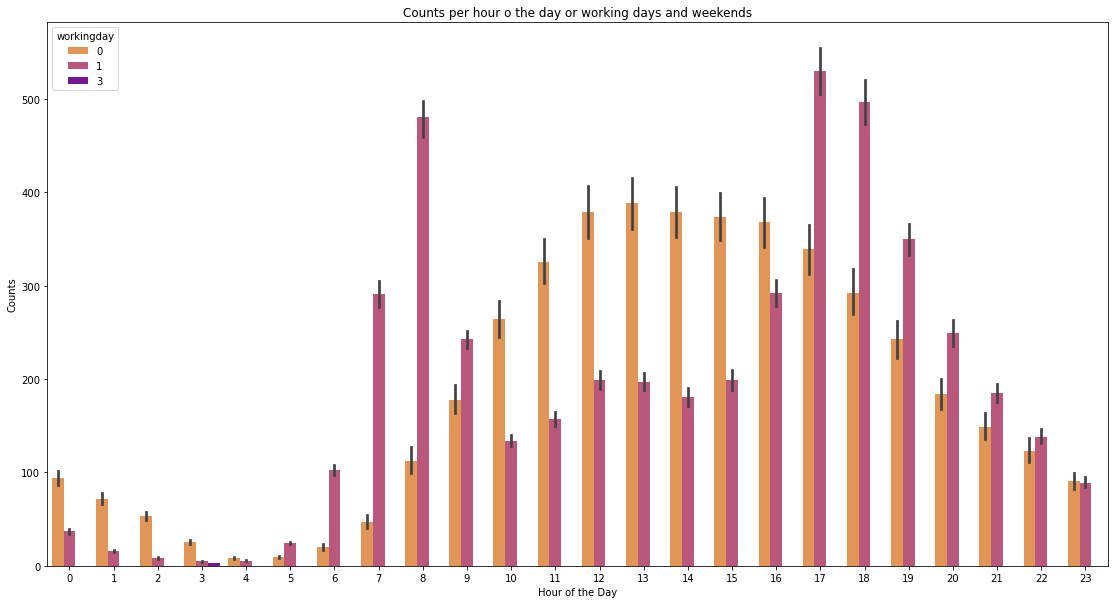

In [217]:
plt.figure(figsize=(19,10))
sns.barplot(data =df, x = 'hour', y ='count', hue = 'workingday', palette='plasma_r', )
plt.xlabel('Hour of the Day')
plt.ylabel('Counts')
plt.title('Counts per hour o the day or working days and weekends')
plt.show()

# Building the model

In [218]:
y = df['count']
X = df[['weather', 'temp', 'atemp', 'humidity', 'windspeed', 
        'holiday', 'workingday', 
        'hour', 'weekday', 'month', 'month_count', 'season', 
        ]]

In [219]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state=42) 

# Transform the Count variable: 
### We use a logarithmic transformation to optimize our error evaluation which is the Root mean Squared Log Error

* In this way we also make sure we do not predict negative counts

In [220]:
ylog_train = np.log1p(y_train)
ylog_test = np.log1p(y_test)

Data transormation pipelines:

In [221]:
numerical_pipeline = Pipeline([
    ('num_scaler',StandardScaler()),
    ('polynomial', PolynomialFeatures(degree= 3,)),
])

In [222]:
categorical_pipeline = Pipeline([
    ('categorical_ohe',OneHotEncoder(sparse=False, drop='first')),
])

In [223]:
polynomial_pipeline_4 = Pipeline([
    ('polynomial', PolynomialFeatures(degree= 4,)),
])

In [224]:
column_transformer = ColumnTransformer([
    ('numerical_pipeline',numerical_pipeline,['atemp', 'humidity', 'windspeed', ]),                        #scal,poly3
    ('polynomial_4', polynomial_pipeline_4, ['month_count',]),                                             #poly4
    ('categorical_pipeline',categorical_pipeline,['hour', 'weekday', 'workingday', 'holiday', 'weather',]),#ohe
])

In [225]:
column_transformer.fit(X_train) 
X_train_fe = column_transformer.transform(X_train) 
X_test_fe = column_transformer.transform(X_test)

# What is done until now is:
##                            1) Follow the general x^4 monthly mean trend. This should be replaced with a sinusoid + a linear increase in general but for the two years is fine.
##                            2) Define a factor to add/subtract according to the day of the week, the hour, holiday or not, and the weather conditions.
##                            3) Include temperature, humidity, and wind speed with an x^3 fitting curve, although a logarithm would sound better intuitively since our perception is logarithmic
## With this feature engineering, a linear regression scored 0.62582.
##                            But what if the weather for example affects the weekends more than Mondays? Or if humidity affects the winter months more? Our model until now cannot include such information. A first try is done here by including interactions. For now, all interactions are included but more work needs to be done here to separate the important ones. This improves the score aprox. 0.2

In [227]:
poly = PolynomialFeatures(degree= 2, interaction_only=True)
poly.fit(X_test_fe)
X_train_fe_int = poly.transform(X_train_fe)
X_test_fe_int = poly.transform(X_test_fe)

In [228]:
m = LinearRegression()
m.fit(X_train_fe_int,ylog_train)
m.score(X_train_fe_int,ylog_train)

0.9670102323273212

In [229]:
cross_val_score(m, X_train_fe_int, ylog_train,cv = 5).mean()

0.9424709357346591

In [230]:
m.score(X_test_fe_int,ylog_test)

0.9485683701415495

In [231]:
y_predlog = m.predict(X_test_fe_int)

In [232]:
ypred = np.exp(y_predlog)-1

In [233]:
from sklearn.metrics import mean_squared_log_error
mean_squared_log_error(y_test, ypred)


0.10587227750028587

In [234]:
from sklearn.metrics import mean_absolute_error
mean_absolute_error(y_test, ypred)

27.633823166473434

In [235]:
train_pred_log = m.predict(X_train_fe_int)
train_pred = np.exp(train_pred_log)-1 
diff = (train_pred - y_train)
diff.describe()

count    8708.000000
mean       -2.166278
std        39.063240
min      -329.703278
25%       -14.090313
50%        -0.412119
75%        10.914369
max       345.573454
Name: count, dtype: float64

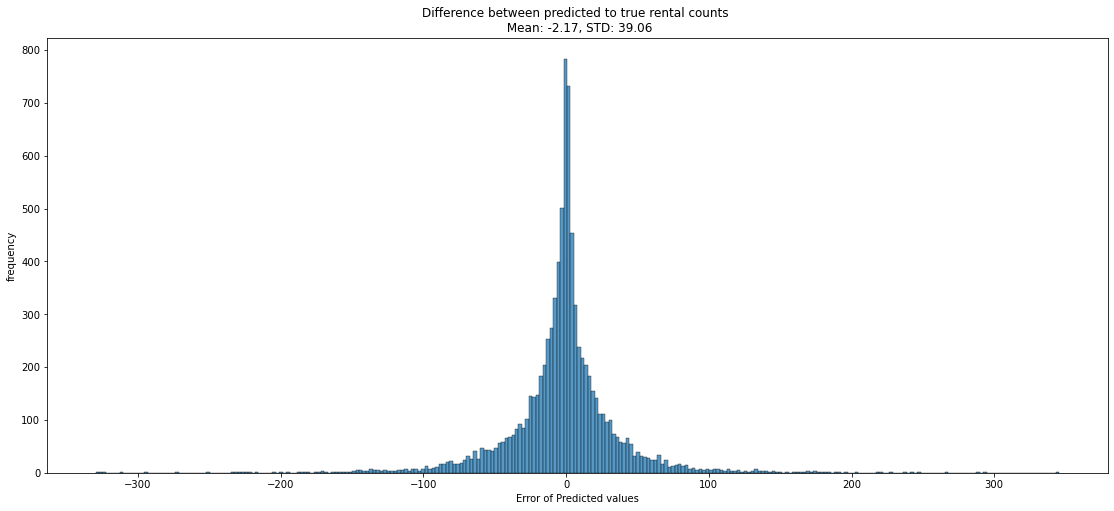

In [236]:
plt.figure(figsize=(19,8))
sns.histplot(diff)
plt.ylabel('frequency')
plt.xlabel('Error of Predicted values')
plt.title(f'Difference between predicted to true rental counts \n Mean: {diff.mean():.2f}, STD: {diff.std():.2f}')
plt.show()

In [237]:
X_train['ypred'] = m.predict(X_train_fe_int)
X_train['ytrue'] = ylog_train

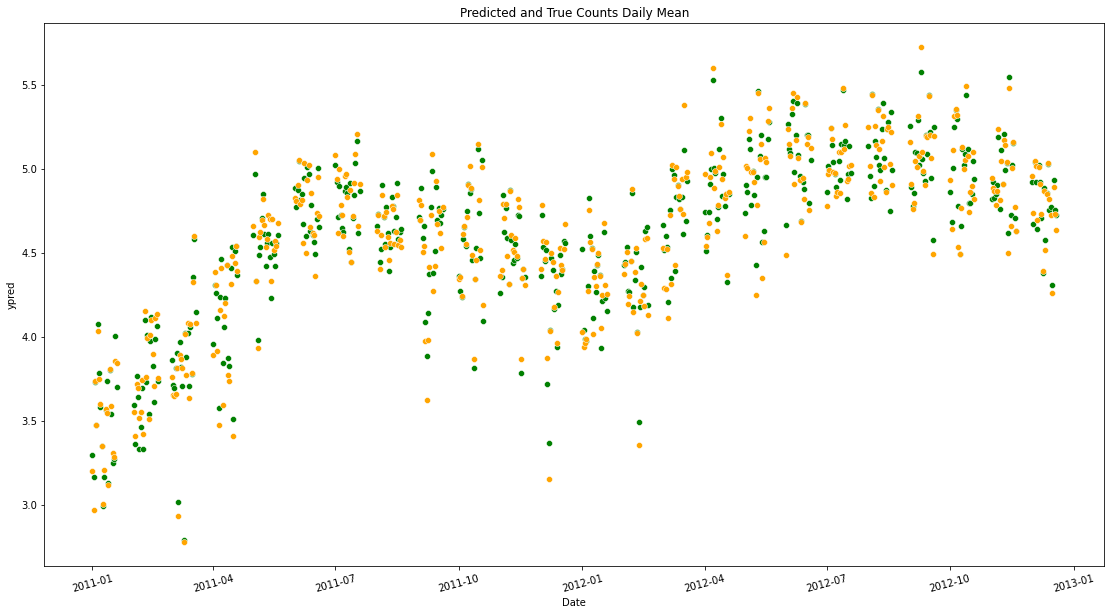

In [238]:
plt.figure(figsize=(19,10))
sns.scatterplot(data =X_train.resample('D').mean(), x = 'datetime', y = 'ypred', color = 'green')
sns.scatterplot(data =X_train.resample('D').mean(), x = 'datetime', y = 'ytrue', color = 'orange' )
plt.xticks(rotation=15)
#plt.ylabel('Counts')
plt.xlabel('Date')
plt.title('Predicted and True Counts Daily Mean')
plt.show()

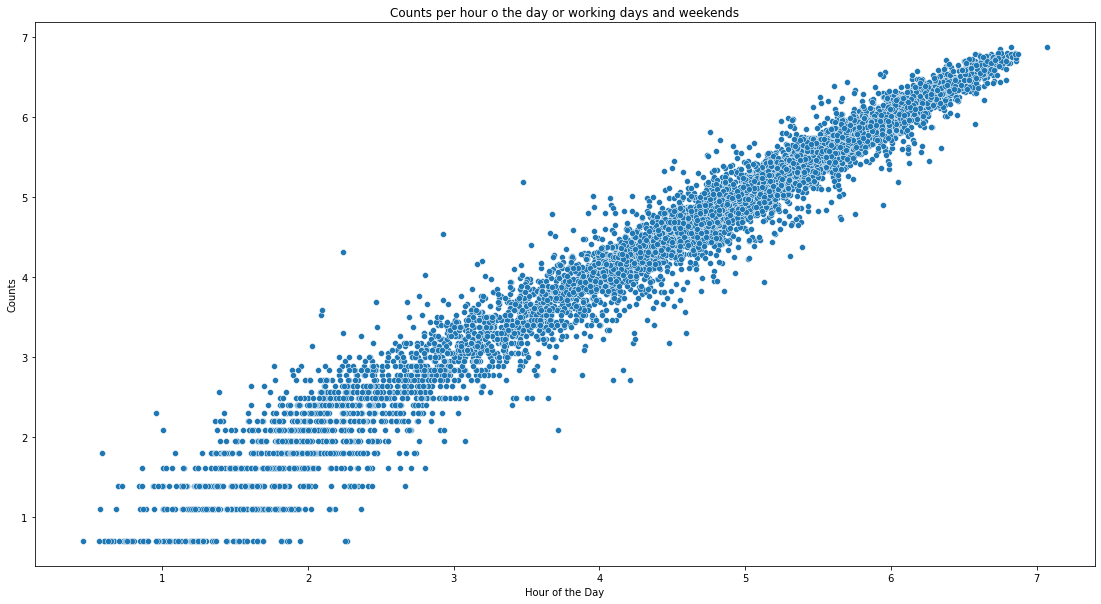

In [254]:
plt.figure(figsize=(19,10))
sns.scatterplot(data =X_train, y ='ytrue',  x ='ypred', )
#sns.barplot(data =X_train, x = 'hour', )
#plt.xlabel('Hour of the Day')
#plt.ylabel('Counts')
#plt.title('Counts per hour o the day or working days and weekends')
plt.show()

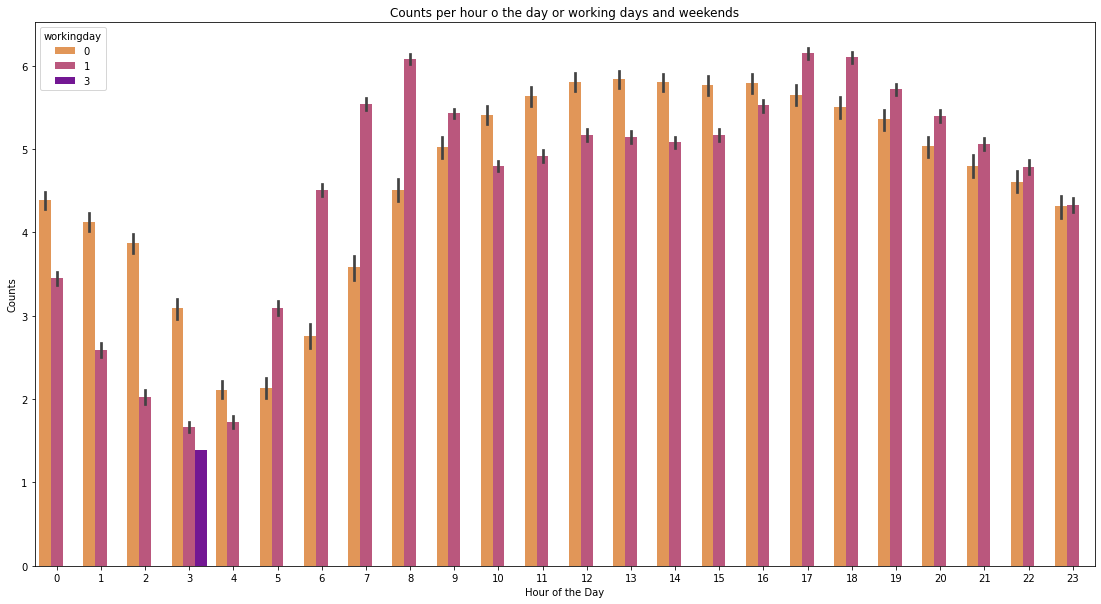

In [248]:
plt.figure(figsize=(19,10))
#sns.barplot(data =X_train, x = 'hour', y ='ytrue', hue = 'workingday', palette='plasma_r', )
sns.barplot(data =X_train, x = 'hour', y ='ypred', hue = 'workingday', palette='plasma_r', )
plt.xlabel('Hour of the Day')
plt.ylabel('Counts')
plt.title('Counts per hour o the day or working days and weekends')
plt.show()

In [241]:
df_k = pd.read_csv('../data/test.csv', index_col=0, parse_dates=True)
df_k.shape

(6493, 8)

In [242]:
df_k['hour'] = df_k.index.hour
df_k['weekday'] = df_k.index.weekday
df_k['month'] = df_k.index.month
df_k['year'] = df_k.index.year
df_k['month_count'] = df_k['month']+(df_k['year'] - 2011)*12
df_k[df_k['weather']==4] = 3

In [243]:
X_test_kaggle = df_k[['season', 'holiday', 'workingday', 'weather', 'temp',
                     'atemp', 'humidity', 'windspeed', 'weekday', 'hour', 'month_count',]]

In [244]:
X_test_kaggle_fe = column_transformer.transform(X_test_kaggle) 
X_test_kaggle_fe = poly.transform(X_test_kaggle_fe) 

In [245]:
y_predlog_k = m.predict(X_test_kaggle_fe)
ypred_k = np.exp(y_predlog_k-1)


### Making sure there are no negative values that would give error in kaggle scoring

In [246]:
np.where(ypred_k<0)

(array([], dtype=int64),)

In [247]:
df_s = pd.read_csv('../data/sampleSubmission.csv', index_col=0, parse_dates=True)
df_s['count'] = ypred_k
pd.DataFrame(df_s).to_csv("predictions")

# Kaggle score 0.44596